# NEXRAD Demo

This is a very crude demo of how to access the NEXRAD data.
Please suggest improvements!

In [1]:
from datetime import datetime, timedelta
import os

import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
import xarray as xr

from util.nexrad.namingconventions import get_grib2_fname
from util.nexrad.nexrad import TimeRange

First we need to specify where the data is located.
Depending on how you mount the data directory, this may be different.
See the `README.md` file on GitHub.

In [2]:
#RDF_DIR = "/home/jd82/RDF/jd82" # this works on linux
RDF_DIR = "Z:\jd82"  #windows directory
datadir = os.path.join(RDF_DIR, "NEXRAD")
os.path.isdir(datadir)

True

Next we specify the data we want to read.
For the purposes of this study, let's look at Hurricane Harvey.
We use the `TimeRange` class from the `util.nexrad` package, which provides some helpful features

In [12]:
t_start = datetime(2017, 8, 25, 0)
t_end = datetime(2017, 8, 30, 23)
t_all = TimeRange(t_start, t_end)

Now leverage the built-in package to get the filename corresponding to each given hour time stamp.
The `TimeRange` has two fields, `dt_all` which includes all hours betweeen the start and end time, and `dt_valid` which includes only those for which data is not known to be missing.

In [13]:
all_files = [get_grib2_fname(t, dirname=datadir) for t in t_all.dt_valid]
len(all_files)

144

We can view the first few files as follows.
Note that these are currently `grib2` files.

In [14]:
all_files[0:3]

['Z:\\jd82\\NEXRAD\\2017\\08\\25\\GaugeCorr_QPE_01H_00.00_20170825-000000.grib2',
 'Z:\\jd82\\NEXRAD\\2017\\08\\25\\GaugeCorr_QPE_01H_00.00_20170825-010000.grib2',
 'Z:\\jd82\\NEXRAD\\2017\\08\\25\\GaugeCorr_QPE_01H_00.00_20170825-020000.grib2']

Now read them all in using the power of xarray.

> **Important:** you need to have the `cfgrib` package installed. It should work out of the box if you add it to your conda environment. This essential package provides the "engine" to read in grib files.

See also the `open_mfdataset` docs.

In [15]:
ds = xr.open_mfdataset(all_files, combine="nested", concat_dim="time", engine="cfgrib")  #added engine="cfgrib"
ds

<xarray.Dataset> Size: 14GB
Dimensions:         (time: 144, latitude: 3500, longitude: 7000)
Coordinates:
  * time            (time) datetime64[ns] 1kB 2017-08-25 ... 2017-08-30T23:00:00
    step            timedelta64[ns] 8B 00:00:00
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    valid_time      (time) datetime64[ns] 1kB 2017-08-25 ... 2017-08-30T23:00:00
Data variables:
    unknown         (time, latitude, longitude) float32 14GB dask.array<chunksize=(1, 3500, 7000), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2024-06-06T16:46 GRIB to CDM+CF via cfgrib-0.9.1...

Unfortunately the attributes of the precipitation data were not encoded correctly.

In [16]:
ds = ds.rename({"unknown": "precip"})
ds.precip.attrs["units"] = "mm"
precip = ds["precip"]
precip

<xarray.DataArray 'precip' (time: 144, latitude: 3500, longitude: 7000)> Size: 14GB
dask.array<concatenate, shape=(144, 3500, 7000), dtype=float32, chunksize=(1, 3500, 7000), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 1kB 2017-08-25 ... 2017-08-30T23:00:00
    step            timedelta64[ns] 8B 00:00:00
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    valid_time      (time) datetime64[ns] 1kB 2017-08-25 ... 2017-08-30T23:00:00
Attributes: (12/29)
    GRIB_paramId:                             0
    GRIB_dataType:                            ra
    GRIB_numberOfPoints:                      24500000
    GRIB_typeOfLevel:                         heightAboveSea
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                unknown
    GRIB_shortName:                           unknown
    GRIB_units:                               unknown
    long_name:                                unknown
    units:                                    mm
    standard_name:                            unknown

Worse, missing values are encoded as -3.0 rather than missing...

In [18]:
precip = precip.where(precip >= 0.0)

Next, we can subset our data.
We don't need to look at all of CONUS, a small area is fine.

> **Note** the `.compute()` command, which forces the computer to read the actual data, rather than just the metadata (which is what it does by default).This may take a while since the RDF is surprisngly slow! You don't usually need to force this in practice, it's just included as a demonstration.

In [19]:
tx_precip = precip.sel(longitude=slice(257.4, 272.5), latitude=slice(37.5, 22.5)).compute()
tx_precip

<xarray.DataArray 'precip' (time: 144, latitude: 1500, longitude: 1510)> Size: 1GB
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time            (time) datetime64[ns] 1kB 2017-08-25 ... 2017-08-30T23:00:00
    step            timedelta64[ns] 8B 00:00:00
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 12kB 37.5 37.49 37.48 ... 22.52 22.51
  * longitude       (longitude) float64 12kB 257.4 257.4 257.4 ... 272.5 272.5
    valid_time      (time) datetime64[ns] 1kB 2017-08-25 ... 2017-08-30T23:00:00
Attributes: (12/29)
    GRIB_paramId:                             0
    GRIB_dataType:                            ra
    GRIB_numberOfPoints:                      24500000
    GRIB_typeOfLevel:                         heightAboveSea
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                unknown
    GRIB_shortName:                           unknown
    GRIB_units:                               unknown
    long_name:                                unknown
    units:                                    mm
    standard_name:                            unknown

For plotting, let's compute hourly to daily data.

> **Note** we set `skipna=False` so that the locations with missing data (ie, places where there are no observations) show up as missing rather than as zero.

In [20]:
daily_precip = tx_precip.groupby("time.date").sum(skipna=False)

Now we can plot it using xarray's [built-in plotting](https://docs.xarray.dev/en/latest/user-guide/plotting.html#maps) to visualize.

> **Important**: this isn't the place to go into detail on colormaps, but you should never use the "jet" colormap. See [here](https://www.domestic-engineering.com/drafts/viridis/viridis.html) and many other places on the web for discussion. However, for precipitation where being able to distinguish multiple ranges is helpful, colormaps like viridis are not always ideal. [Turbo](https://research.google/blog/turbo-an-improved-rainbow-colormap-for-visualization/) is a nice choice.

See the xarray plotting docs for an explanation and details of this plot.

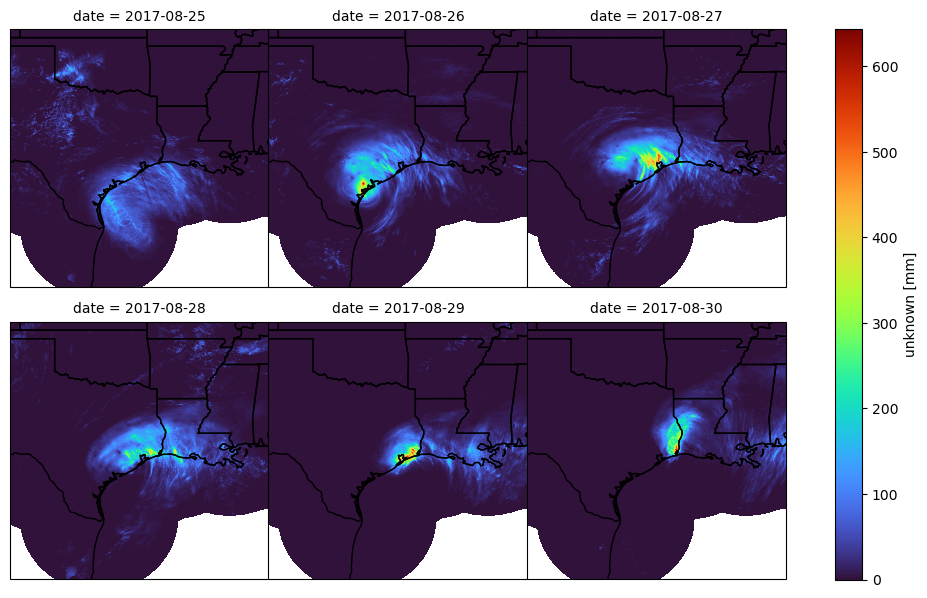

In [21]:
p = daily_precip.plot(
    col="date", # create a subplot based on the dimension of the data
    col_wrap=3, # no more than 3 columns
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    transform=ccrs.PlateCarree(),
    cmap="turbo",
)

for ax in p.axs.flat:
    ax.coastlines()
    ax.add_feature(feature.STATES)

plt.draw()

And last, we can write to netcdf for use with other programs.

> **TODO:** make sure this output file is compatible with HEC-RAS 2D

In [22]:
tx_precip.to_netcdf("demo_netcdf_file.nc", format="netcdf4")